# Long Short Term Memory
## A simple guide using keras library 

In [2]:
import h5py
import keras 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

In [3]:
filename = 'supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'].value
labels       = f['labels'].value
ids          = f['sne_id'].value
np.unique(labels)

array([ 1,  2,  3, 21, 22, 23, 32, 33], dtype=int32)

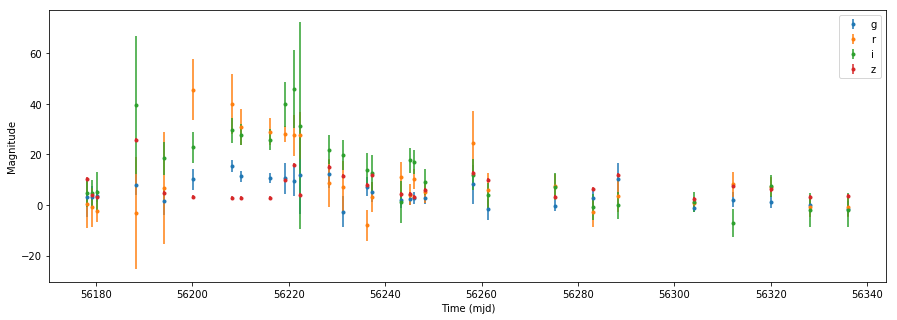

In [4]:
selected = light_curves[labels == 1][0]
plt.figure(figsize=(15,5))
plt.errorbar(selected[:,0], selected[:,1], yerr=selected[:,5], label='g', fmt='.')
plt.errorbar(selected[:,0], selected[:,2], yerr=selected[:,6], label='r', fmt='.')
plt.errorbar(selected[:,0], selected[:,3], yerr=selected[:,7], label='i', fmt='.')
plt.errorbar(selected[:,0], selected[:,4], yerr=selected[:,8], label='z', fmt='.')
plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.show()

## Data Preprocessing 

In order to avoid the vanish or explode gradient problem we need to scale our data. Preprocessing package from scikit-learn provide a StandarScaler class which normalize the data using the mean and standar deviation for each feature.
<br><br><center>$
\hat{x} = \frac{x - \bar{x}}{\sigma_x}
$<center>

In [5]:
scaler = preprocessing.StandardScaler()
x_scaled = np.array([scaler.fit_transform(x) for x in light_curves])

# One hot encoding 
y_onehot = pd.get_dummies(labels).values

In [6]:
np.unique(y_onehot, axis=0)

array([[0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

#### Split data to perform training 

In [7]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_onehot, test_size=0.3, random_state=42, shuffle=True)
print('Train dimensionality: {}\nTest dimensionality:  {}'.format(x_train.shape, x_test.shape))

Train dimensionality: (50137, 30, 9)
Test dimensionality:  (21488, 30, 9)


## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, Input
from keras.callbacks import EarlyStopping

In [11]:
# Params 
batch_size   = 128 # Training batch size
n_steps      = x_train.shape[1] # Number of time steps into the serie 
n_channels   = x_train.shape[2] # Number of attributes such as magnitudes and errors
n_classes    = np.unique(labels).shape[0] 

n_neurons    = 16  # Neurons in each gate of LSTM

dropout_prob = 0.2 # Fraction of the units to drop 
n_epochs     = 50  # Max number of epochs on training
patience     = 5   # Number of epochs with no improvement

In [12]:
inputs = Input(shape=(n_steps, n_channels))

x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs)
x = LSTM(n_neurons, dropout=dropout_prob)(x)
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 16)            1664      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 4,184
Trainable params: 4,184
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x=x_train,  
                    y=y_train, 
                    batch_size=batch_size, 
                    epochs=n_epochs, 
                    validation_split=0.3,
                    shuffle=True,
                    callbacks = [EarlyStopping(patience=patience)])

Train on 35095 samples, validate on 15042 samples
Epoch 1/50
35095/35095 [==============================] - 8s 229us/step - loss: 1.3029 - acc: 0.5833 - val_loss: 0.9728 - val_acc: 0.7175
Epoch 2/50
35095/35095 [==============================] - 8s 222us/step - loss: 0.9539 - acc: 0.7116 - val_loss: 0.8423 - val_acc: 0.7530
Epoch 3/50
35095/35095 [==============================] - 8s 231us/step - loss: 0.8810 - acc: 0.7375 - val_loss: 0.8107 - val_acc: 0.7587
Epoch 4/50
35095/35095 [==============================] - 7s 212us/step - loss: 0.8579 - acc: 0.7425 - val_loss: 0.7946 - val_acc: 0.7650
Epoch 5/50
35095/35095 [==============================] - 8s 224us/step - loss: 0.8367 - acc: 0.7506 - val_loss: 0.7697 - val_acc: 0.7684
Epoch 6/50
35095/35095 [==============================] - 9s 243us/step - loss: 0.8234 - acc: 0.7541 - val_loss: 0.7553 - val_acc: 0.7726
Epoch 7/50
35095/35095 [==============================] - 8s 234us/step - loss: 0.8113 - acc: 0.7561 - val_loss: 0.7459 - 

In [16]:
from sklearn.metrics import accuracy_score
y_probas = model.predict(x_test)
y_pred   = np.argmax(y_probas, axis=1)
y_true   = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_true, y_pred)

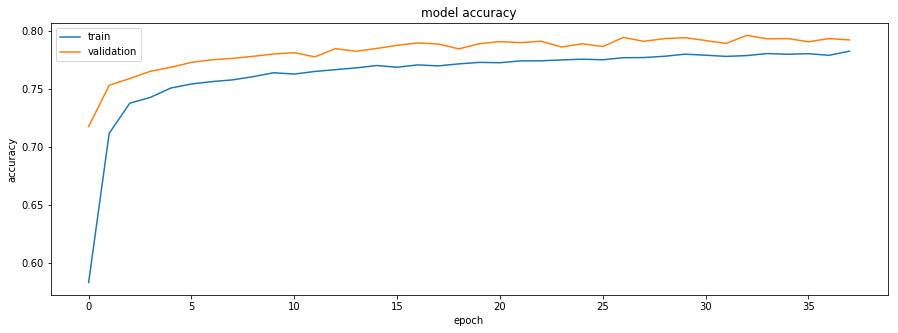

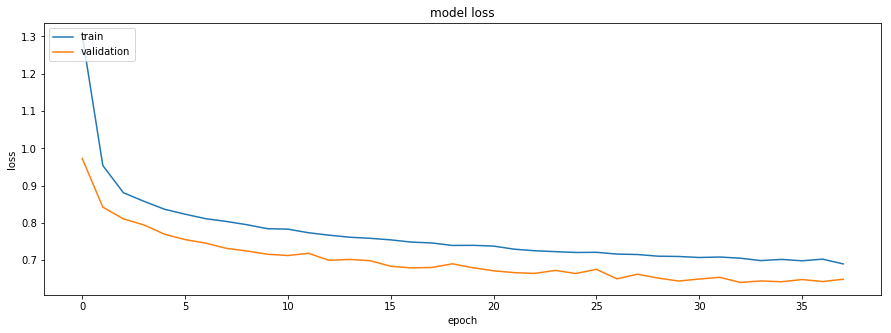

In [17]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

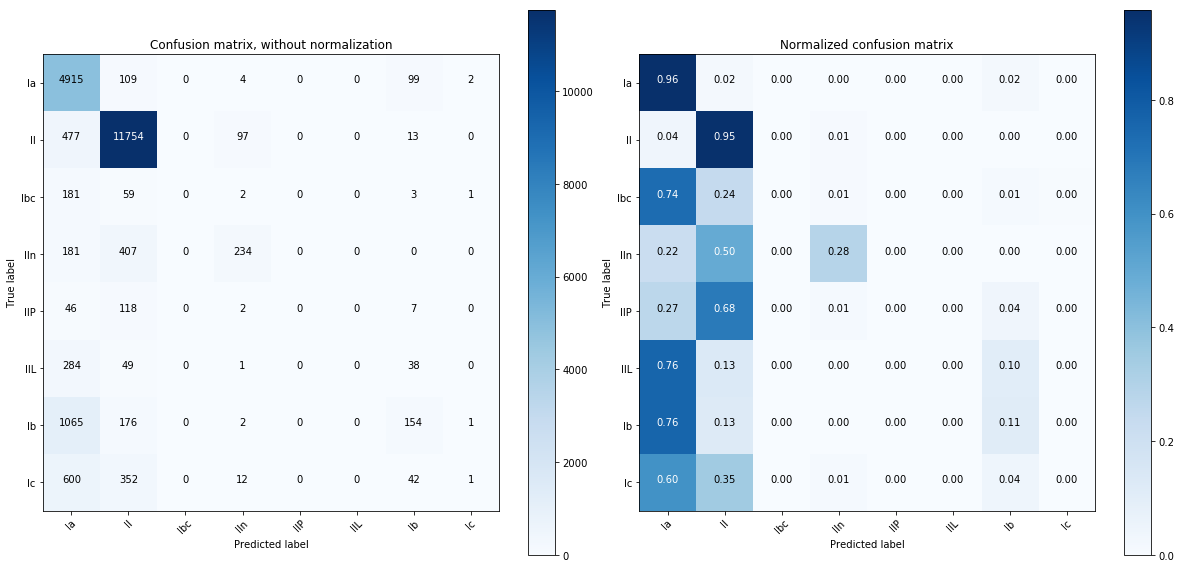

In [18]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(17,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')